# Putting the R(etrieval) in RAG

In [1]:
!python -m pip install -U -qq pinecone

In [2]:
from openai import OpenAI
from pinecone import Pinecone, ServerlessSpec
import hashlib
import os
import re
from datetime import datetime, timezone
from bs4 import BeautifulSoup
import requests

from tqdm import tqdm

In [7]:
# Retrieve the Pinecone API key from user data
pinecone_key = os.environ.get('PINECONE_API_KEY')

# Initialize the OpenAI client with the API key from user data
client = OpenAI(
    api_key=os.environ.get('OPENAI_API_KEY')
)

# Define constants for the Pinecone index, namespace, and engine
ENGINE = 'text-embedding-3-small'  # The embedding model to use (vector size 1,536)

# Initialize the Pinecone client with the retrieved API key
pc = Pinecone(
    api_key=pinecone_key
)


In [9]:
INDEX_NAME = 'rag-basics'  # The name of the Pinecone index
NAMESPACE = 'default'  # The namespace to use within the index

# Function to get embeddings for a list of texts using the OpenAI API
def get_embeddings(texts, engine=ENGINE):
    # Create embeddings for the input texts using the specified engine
    response = client.embeddings.create(
        input=texts,
        model=engine
    )

    # Extract and return the list of embeddings from the response
    return [d.embedding for d in list(response.data)]

# Function to get embedding for a single text using the OpenAI API
def get_embedding(text, engine=ENGINE):
    # Use the get_embeddings function to get the embedding for a single text
    return get_embeddings([text], engine)[0]

# Test the functions by getting the length of a single embedding and a list of embeddings
len(get_embedding('hi')), len(get_embeddings(['hi', 'hello']))

(1536, 2)

In [10]:
if INDEX_NAME not in pc.list_indexes().names():  # need to create the index
    print(f'Creating index {INDEX_NAME}')
    pc.create_index(
        name=INDEX_NAME,  # The name of the index
        dimension=1536,  # The dimensionality of the vectors for our OpenAI embedder
        metric='cosine',  # The similarity metric to use when searching the index
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'
        )
    )

# Store the index as a variable
index = pc.Index(name=INDEX_NAME)
index

Creating index rag-basics


In [11]:
# index.delete(delete_all=True, namespace=NAMESPACE) # TO delete all vectors, be careful!

In [12]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [13]:
def my_hash(s):
    # Return the MD5 hash of the input string as a hexadecimal string
    return hashlib.md5(s.encode()).hexdigest()

my_hash('I love to hash it')

'ae76cc4dfd345ecaeea9b8ba0d5c3437'

In [14]:
def prepare_for_pinecone(texts, engine=ENGINE, urls=None):
    # Get the current UTC date and time
    now = datetime.now(timezone.utc).isoformat()

    # Generate vector embeddings for each string in the input list, using the specified engine
    embeddings = get_embeddings(texts, engine=engine)

    # Create tuples of (hash, embedding, metadata) for each input string and its corresponding vector embedding
    # The my_hash() function is used to generate a unique hash for each string, and the datetime.utcnow() function is used to generate the current UTC date and time
    responses = [
        (
            my_hash(text),  # A unique ID for each string, generated using the my_hash() function
            embedding,  # The vector embedding of the string
            dict(text=text, date_uploaded=now)  # A dictionary of metadata, including the original text and the current UTC date and time
        )
        for text, embedding in zip(texts, embeddings)  # Iterate over each input string and its corresponding vector embedding
    ]
    if urls and len(urls) == len(texts):
        for response, url in zip(responses, urls):
            response[-1]['url'] = url

    return responses


In [15]:
texts = ['hi']

In [16]:
_id, embedding, metadata = prepare_for_pinecone(texts)[0]

print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   49f68a5c8493ec2c0bf489821c21fc3b 
LEN:  1536 
META: {'text': 'hi', 'date_uploaded': '2025-10-21T16:06:34.015837+00:00'}


In [17]:
urls = ['fake.url']
_id, embedding, metadata = prepare_for_pinecone(texts, urls=urls)[0]

print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   49f68a5c8493ec2c0bf489821c21fc3b 
LEN:  1536 
META: {'text': 'hi', 'date_uploaded': '2025-10-21T16:06:35.397368+00:00', 'url': 'fake.url'}


In [18]:
def upload_texts_to_pinecone(texts, namespace=NAMESPACE, batch_size=None, show_progress_bar=False, urls=None):
    # Call the prepare_for_pinecone function to prepare the input texts for indexing
    total_upserted = 0
    if not batch_size:
        batch_size = len(texts)

    _range = range(0, len(texts), batch_size)
    for i in tqdm(_range) if show_progress_bar else _range:
        text_batch = texts[i: i + batch_size]
        if urls:
            url_batch = urls[i: i + batch_size]
            prepared_texts = prepare_for_pinecone(text_batch, urls=url_batch)
        else:
            prepared_texts = prepare_for_pinecone(text_batch)


        # Use the upsert() method of the index object to upload the prepared texts to Pinecone
        total_upserted += index.upsert(
            vectors=prepared_texts,
            namespace=namespace
        )['upserted_count']


    return total_upserted

In [19]:
# Call the upload_texts_to_pinecone() function with the input texts
print(upload_texts_to_pinecone(texts))

index.describe_index_stats()

1


{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [20]:
def query_from_pinecone(query, top_k=3, include_metadata=True):
    # get embedding from THE SAME embedder as the documents
    query_embedding = get_embedding(query, engine=ENGINE)

    return index.query(
      vector=query_embedding,
      top_k=top_k,
      namespace=NAMESPACE,
      include_metadata=include_metadata   # gets the metadata (dates, text, etc)
    ).get('matches')

In [21]:
# test that the index has a vector
query_from_pinecone('hello')

[]

In [22]:
import hashlib

def delete_texts_from_pinecone(texts, namespace=NAMESPACE):
    # Compute the hash (id) for each text
    hashes = [hashlib.md5(text.encode()).hexdigest() for text in texts]

    # The ids parameter is used to specify the list of IDs (hashes) to delete
    return index.delete(ids=hashes, namespace=namespace)

# delete our text
delete_texts_from_pinecone(texts)


{}

In [23]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

# "Borrowing" Government Data

In [26]:
base_url = 'https://faq.ssa.gov'
medicare_faqs = base_url + '/en-US/topic?id=CAT-01092'
print(medicare_faqs)

http://faq.ssa.gov/en-US/topic?id=CAT-01092


In [29]:
def find_links_with_pattern(url, pattern):
    # Send a GET request to the URL
    response = requests.get(url, verify=False)  # 47 let the SSLs expire..
    
    # Create a BeautifulSoup object
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Compile the regex pattern
    regex = re.compile(pattern)
    
    # Find all 'a' tags with href attribute matching the pattern
    links = soup.find_all('a', href=regex)
    
    # Extract and return the href values
    return [link.get('href') for link in links]

# Example usage
pattern = r'^/en-US'

matching_links = find_links_with_pattern(base_url, pattern)
len(matching_links)

/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'faq.ssa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'faq.ssa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


19

In [32]:
urls = []

for matching_link in tqdm(matching_links):
    r = requests.get(base_url + matching_link, verify=False)
    soup = BeautifulSoup(r.content, 'html.parser')
    for link in soup.find_all('a'):
        if 'href' in link.attrs:
            if link['href'].startswith('/') and 'article' in link['href']:
                urls.append(base_url + link['href'])
    
urls = list(set([u.lower().strip() for u in urls]))
len(urls)

  0%|                                                                                                     | 0/19 [00:00<?, ?it/s]/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'faq.ssa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  5%|████▉                                                                                        | 1/19 [00:01<00:28,  1.57s/it]/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'faq.ssa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 11%|█████████▊                                                                 

113

In [33]:
urls[0]

'http://faq.ssa.gov/en-us/topic/article/ka-01759'

In [64]:
dirty_government_docs = []
for url in tqdm(urls):
    r = requests.get(url, verify=False)
    soup = BeautifulSoup(r.content, 'html.parser')
    dirty_government_docs.append((soup.find('body').get_text(), url))

  0%|                                                                                                    | 0/113 [00:00<?, ?it/s]/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'faq.ssa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  1%|▊                                                                                           | 1/113 [00:02<04:02,  2.17s/it]/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'faq.ssa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  2%|█▋                                                                         

In [76]:
def clean_string(text):  # courtesy of Claude 3.5 Sonnet
    # Remove extra whitespace, including newlines
    text = re.sub(r'\s+', ' ', text)
    # Remove any leading/trailing whitespace
    text = text.strip()
    # Remove common filler phrases
    filler_phrases = [
        "Skip to content", "Skip to main content", "Menu", "Sign in", "Print", "Views:", "Comments \(0\)",
        "Footer menu", "Give us Feedback.", "Did this answer your question?", "No Yes No", "Thanks for your feedback."
    ]
    for phrase in filler_phrases:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)
    # Remove any remaining brackets and their contents
    text = re.sub(r'\[.*?\]', '', text)
    # Remove any remaining parentheses and their contents
    text = re.sub(r'\(.*?\)', '', text)
    # Remove any URLs
    text = re.sub(r'http\S+', '', text)
    # Remove any remaining special characters
    text = re.sub(r'[^\w\s\.\,\?\!]', '', text)
    # Remove extra spaces that may have been created
    text = re.sub(r'\s+', ' ', text).strip()

    text = text.split('FAQ Home Topics')[-1]
    text = text.split('More Information')[0]
    text = text.split('Footer ?')[0]

    text = text.strip()
    return text

In [77]:
government_docs = []
for body, url in dirty_government_docs:
    government_docs.append(dict(text=clean_string(body), url=url))

In [78]:
government_docs[0]

{'text': 'KA01759 How do I file W2s, W2Cs, and W3s for my employees? Employers and third parties can easily file wage reports with us electronically or by paper . The Internal Revenue Service has issued final regulations that reduce the electronic filing threshold from 250 W2s to 10 informational returns, effective January 2024. If you file 10 or more informational returns , you must file electronically unless the IRS grants a waiver or exemption. There are three ways to file electronically Use our free product, W2 Online, which allows you to file W2s and W2Cs right from our Business Services Online webpage. Use software that produces W2 forms in the Electronic Filing W2 format and upload your file on our BSO webpage. Use a commercial software product that allows you to file W2s electronically with us using the software. Note You also have the option for a third party to prepare the W2s and file them electronically with us. The third party normally charges a fee.',
 'url': 'http://faq.

In [79]:
government_docs[-1]

{'text': 'KA02154 Will my Medicare premiums be higher because of my higher income? Some people with higher income may pay a larger percentage of their monthly Medicare Part B and prescription drug costs based on their income. We call the additional amount the incomerelated monthly adjustment amount. Visit Medicare Premiums Rules For HigherIncome Beneficiaries to see if the adjustment amount applies to you.',
 'url': 'http://faq.ssa.gov/en-us/topic/article/ka-02154'}

In [80]:
index.delete(delete_all=True, namespace=NAMESPACE) # TO delete all vectors, be careful!

{}

In [81]:
BATCH_SIZE = 32
upload_texts_to_pinecone(
    texts=[g['text'] for g in government_docs],
    batch_size=BATCH_SIZE, show_progress_bar=True, 
    urls=[g['url'] for g in government_docs]
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.30s/it]


113

In [82]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [83]:
query = 'I lost my medicare card'

results = query_from_pinecone(query, top_k=10)
for result in results:
    print(result['metadata']['url'], result['score'], result['metadata']['text'][-50:])

http://faq.ssa.gov/en-us/topic/article/ka-02713 0.438835174 rmation, go to the How to drop Part A Part B page.
http://faq.ssa.gov/en-us/topic/article/ka-02017 0.484854728 er card? How do I get a replacement Medicare card?
http://faq.ssa.gov/en-us/topic/article/ka-02244 0.462783843 Income, contact your local Social Security office.
http://faq.ssa.gov/en-us/topic/article/ka-02131 0.454951346 more information go to our Medicare Benefits page.
http://faq.ssa.gov/en-us/topic/article/ka-01735 0.685358107 o order a replacement card to be sent in the mail.
http://faq.ssa.gov/en-us/topic/article/ka-02125 0.449957877 or more information read our Medicare publication.
http://faq.ssa.gov/en-us/topic/article/ka-02989 0.434897482 elpfulWhat are Medicare late enrollment penalties?
http://faq.ssa.gov/en-us/topic/article/ka-02137 0.430703193 nts and help you apply. For more information see .
http://faq.ssa.gov/en-us/topic/article/ka-02113 0.429694235 rug coverage helps pay for prescribed medications.
h

In [84]:
results[0]

{'id': '0acc5a5480436f5c668dd7bacc739283',
 'metadata': {'date_uploaded': '2025-10-21T16:26:40.763960+00:00',
              'text': 'KA02713 How do I terminate my Medicare Part B ? You can '
                      'voluntarily terminate your Medicare Part B . However, '
                      'you may need to have a personal interview with us to '
                      'review the risks of dropping coverage and for '
                      'assistance with your request. To find out more about '
                      'how to terminate Medicare Part B or to schedule a '
                      'personal interview, contact us at 18007721213 or visit '
                      'your nearest Social Security office. If you send us a '
                      'request to terminate your Part B and then change your '
                      'mind, you must send a request to cancel the request of '
                      'termination before the date that Part B ends. For '
                      'additional i

# Using Open Source Embedders

In [85]:
from sentence_transformers import SentenceTransformer, util

open_source_embedder = SentenceTransformer('all-MiniLM-L6-v2')

open_source_embedder.encode(['hi', 'hello', 'sup']).shape

# It's that easy! The hard part is evaluating them :)

/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(3, 384)

In [86]:
open_source_embedder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

# Synthetic Test Data Generation

In [92]:
# pip install langchain langchain-openai pydantic
import os
from typing import List, Literal
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

# ---- Structured schema ----
class SyntheticQuestions(BaseModel):
    """Ten user questions derived strictly from the provided document text."""
    english_questions: List[str] = Field(
        ...,
        description=(
            "Exactly 5 English questions"
        ),
    )
    spanish_questions: List[str] = Field(
        ...,
        description=(
            "Exactly 2 Spanish questions"
        ),
    )
    chinese_questions: List[str] = Field(
        ...,
        description=(
            "Exactly 2 Chinese questions"
        ),
    )
    french_questions: List[str] = Field(
        ...,
        description=(
            "Exactly 2 French questions"
        ),
    )
# ---- LLM & prompt ----
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=1.0)

prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are generating fair user questions that can be "
     "answered strictly from the provided document. Do not add external facts."
     "Everything must be answerable using the document below"),
    ("human",
     "I am designing a chatbot that uses the document below.\n\n"
     "Please write 10 distinct questions an average (non-expert) user might ask that "
     "can DEFINITELY be answered using only this document. Make them a bit "
     "confusing (but fair) to stress-test retrieval.\n\n"
     "Language REQUIREMENTS (exactly 10):\n"
     "1–5: English\n6–7: Spanish\n8–9: Chinese\n10: French\n\n"
     "Return ONLY structured JSON matching the schema, no extra commentary.\n\n"
     "Document:\n{document}")
])

structured_llm = llm.with_structured_output(SyntheticQuestions)
chain = prompt | structured_llm


In [93]:
# government_docs is your existing list; we mirror your original index [1]
result: SyntheticQuestions = chain.invoke({
    "document": government_docs[0]["text"]
})

print(result.model_dump_json(indent=2))

{
  "english_questions": [
    "What is the new electronic filing threshold for W2s starting in January 2024?",
    "Can a third party file my employees' W2s electronically without me filing them myself?",
    "What options are available to file W2s electronically through the IRS?",
    "Is it possible to file W2s on paper if I have fewer than 10 informational returns?",
    "What happens if I file 10 or more informational returns but do not file electronically or get a waiver?"
  ],
  "spanish_questions": [
    "¿Cuándo entran en vigor las nuevas regulaciones para presentar electrónicamente W2 y W3?",
    "¿Puedo usar un software comercial para presentar electrónicamente los formularios W2?"
  ],
  "chinese_questions": [
    "如果我有10个或更多的W2信息申报表，我必须怎样提交？",
    "是否可以用IRS提供的免费产品在线提交W2和W2C表格？"
  ],
  "french_questions": [
    "Quels sont les moyens de déposer les formulaires W2 électroniquement selon la réglementation ?"
  ]
}


In [94]:
synthetic_questions = []
from random import sample

# generate synthetic test data for a sample  of the urls found
SAMPLE = .2
for i, government_doc in enumerate(tqdm(sample(government_docs, int(len(government_docs) * SAMPLE)))):
        
    result = chain.invoke({"document": government_doc['text']})
    try:
        for language in ('english', 'spanish', 'french', 'chinese'):
            for question in getattr(result, f'{language}_questions'):
                synthetic_questions.append(
                dict(
                    language=language, 
                    query=question, 
                    expected_hash=my_hash(government_doc['text'])
                )
            )
    except Exception as e:
        print(f'Could not generate questions for index {i}: {e}')
    

100%|████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [01:34<00:00,  4.30s/it]


In [95]:
len(synthetic_questions)

263

In [96]:
synthetic_questions[0]

{'language': 'english',
 'query': 'What determines the monthly premium amount for Medicare Part B?',
 'expected_hash': '53bb9b1ef444a2a843933749adc1da86'}

In [97]:
def test_query(query, expected_hash, language, top_k=10):
    results = query_from_pinecone(query, top_k=top_k)
    top_result_correct = results[0]['id'] == expected_hash  # accuracy
    result_in_pinecone_list = expected_hash in (r['id'] for r in results)  # Recall@top_k (10, etc)
    return dict(
        result_in_pinecone_list=result_in_pinecone_list, top_result_correct=top_result_correct,
        language=language, expected_hash=expected_hash, top_hash=results[0]['id']
    )

In [98]:
test_query(**synthetic_questions[0])

{'result_in_pinecone_list': True,
 'top_result_correct': True,
 'language': 'english',
 'expected_hash': '53bb9b1ef444a2a843933749adc1da86',
 'top_hash': '53bb9b1ef444a2a843933749adc1da86'}

In [99]:
synthetic_test_results = []
for synthetic_question in tqdm(synthetic_questions):
    synthetic_test_results.append(test_query(**synthetic_question))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 263/263 [02:01<00:00,  2.16it/s]


result_in_pinecone_list    0.996198
top_result_correct         0.847909
dtype: float64


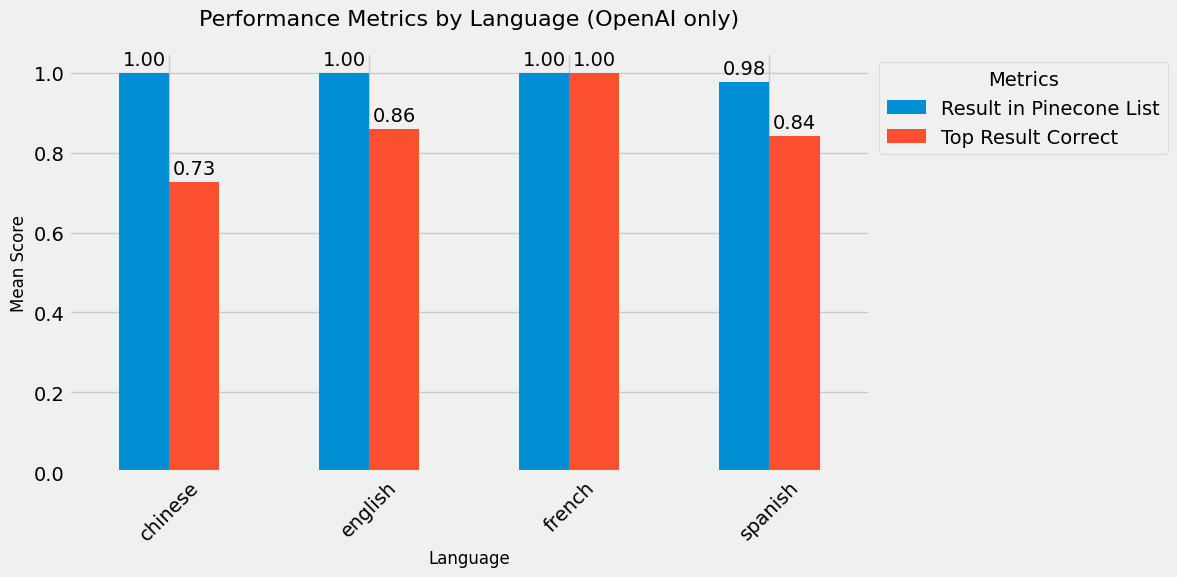

In [104]:
import pandas as pd
results_df = pd.DataFrame(synthetic_test_results)

print(results_df[['result_in_pinecone_list', 'top_result_correct']].mean())

import matplotlib.pyplot as plt

# Assuming you've already created results_df
grouped_data = results_df.groupby('language')[['result_in_pinecone_list', 'top_result_correct']].mean()

# Set the style and color palette
plt.style.use('fivethirtyeight')
# sns.set_palette("deep")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
grouped_data.plot(kind='bar', ax=ax)

# Customize the plot
ax.set_title('Performance Metrics by Language (OpenAI only)', fontsize=16, pad=20)
ax.set_xlabel('Language', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

# Add a legend
ax.legend(['Result in Pinecone List', 'Top Result Correct'], title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Making Retrieval Better with [Cohere](cohere.com/rerank)'s Re-Rank


"Rerank provides a powerful semantic boost to the search quality of any keyword or vector search system without requiring any overhaul or replacement."

In [105]:
%env COHERE_API_KEY=VdXnvh43Nfhic3EyCkG6ExbjRAGFi2baaIMtkQWC


env: COHERE_API_KEY=VdXnvh43Nfhic3EyCkG6ExbjRAGFi2baaIMtkQWC


In [106]:
import cohere

co = cohere.Client(os.environ.get('COHERE_API_KEY'))

In [107]:
docs = [
    "Carson City is the capital city of the American state of Nevada.",
    "The Commonwealth of the Northern Mariana Islands is a group of islands in the Pacific Ocean. Its capital is Saipan.",
    "Capitalization or capitalisation in English grammar is the use of a capital letter at the start of a word. English usage varies from capitalization in other languages.",
    "Washington, D.C. (also known as simply Washington or D.C., and officially as the District of Columbia) is the capital of the United States. It is a federal district.",
    "Capital punishment (the death penalty) has existed in the United States since beforethe United States was a country. As of 2017, capital punishment is legal in 30 of the 50 states.",
]

response = co.rerank(
    model="rerank-english-v3.0",
    query="What is the capital of the United States?",
    documents=docs,
    top_n=1,
)

docs[response.results[0].index] # re-ranks the docs so that the first one is the most semantically similar

'Washington, D.C. (also known as simply Washington or D.C., and officially as the District of Columbia) is the capital of the United States. It is a federal district.'

In [108]:
def test_query_with_cohere(query, expected_hash, language, top_k=10):
        
    results = query_from_pinecone(query, top_k=top_k)
    result_in_pinecone_list = expected_hash in (r['id'] for r in results)    
    docs = [result['metadata']['text'] for result in results]   
        
    response = co.rerank(
        model="rerank-multilingual-v3.0",
        query=query,
        documents=docs,
        top_n=1,
    )

    top_doc = docs[response.results[0].index]
    top_result_correct = my_hash(top_doc) == expected_hash
    
    return dict(
        result_in_pinecone_list=result_in_pinecone_list, top_result_correct=top_result_correct,
        language=language, expected_hash=expected_hash, top_hash=results[0]['id']
    )

In [109]:
test_query_with_cohere(**synthetic_questions[0])

{'result_in_pinecone_list': True,
 'top_result_correct': True,
 'language': 'english',
 'expected_hash': '53bb9b1ef444a2a843933749adc1da86',
 'top_hash': '53bb9b1ef444a2a843933749adc1da86'}

In [110]:
synthetic_test_results_cohere = []
for synthetic_question in tqdm(synthetic_questions):
    synthetic_test_results_cohere.append(test_query_with_cohere(**synthetic_question))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 263/263 [03:06<00:00,  1.41it/s]


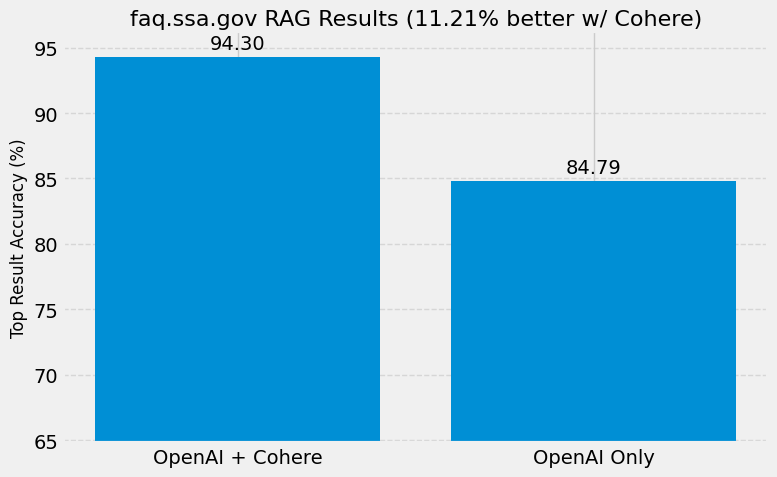

In [114]:
import matplotlib.pyplot as plt

# Data
data = {
    'OpenAI + Cohere': pd.Series([s['top_result_correct'] for s in synthetic_test_results_cohere]).mean() * 100,
    'OpenAI Only': pd.Series([s['top_result_correct'] for s in synthetic_test_results]).mean() * 100
}

percent_change = round((data['OpenAI + Cohere'] - data['OpenAI Only']) / data['OpenAI Only'] * 100, 2)

# Set the style and color palette
plt.style.use('fivethirtyeight')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 5))  # Reduced from (10, 6)

# Plot the data
bars = ax.bar(data.keys(), data.values())

# Customize the plot
ax.set_title(
    f'{base_url.split("//")[-1]} RAG Results ({percent_change}% {"better" if percent_change > 0 else "worse"} w/ Cohere)', 
    fontsize=16, pad=4)
ax.set_ylabel('Top Result Accuracy (%)', fontsize=12)
ax.tick_params(axis='x')

# Add value labels on top of each bar
ax.bar_label(bars, fmt='%.2f', padding=3)

# Adjust y-axis to start from 0.7 for better visualization of differences
ax.set_ylim(min(data.values()) - 20, max(data.values()) + 2)

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [123]:
synthetic_test_results[0]

{'result_in_pinecone_list': True,
 'top_result_correct': True,
 'language': 'english',
 'expected_hash': '53bb9b1ef444a2a843933749adc1da86',
 'top_hash': '53bb9b1ef444a2a843933749adc1da86'}

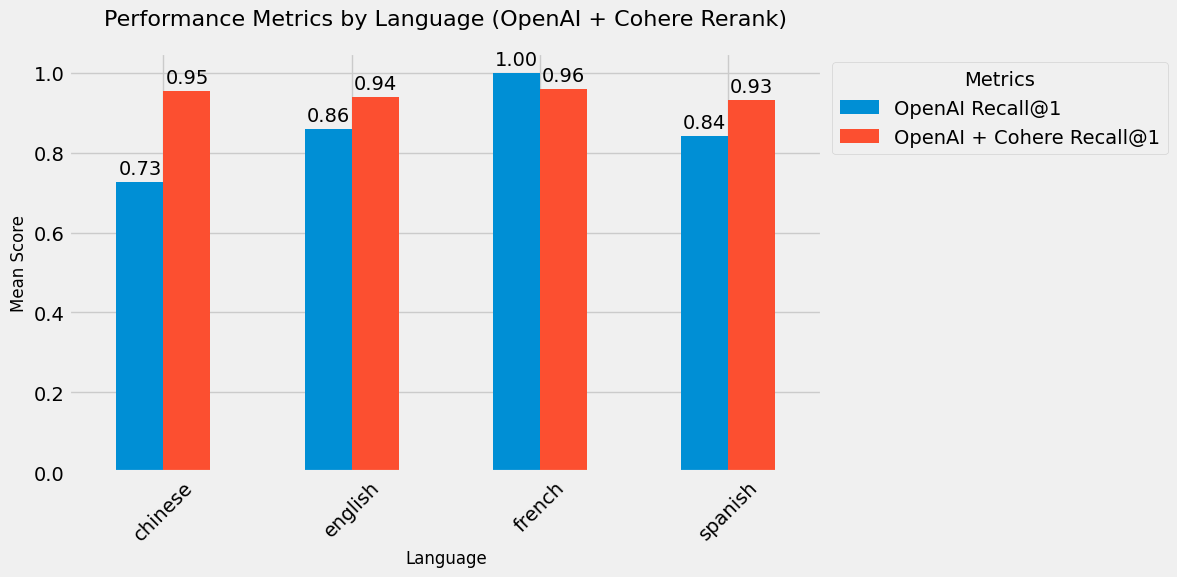

In [127]:
import pandas as pd
results_df = pd.DataFrame({
    'language': [_['language'] for _ in synthetic_test_results],
    'OpenAI Recall@1': [_['top_result_correct'] for _ in synthetic_test_results],
    'OpenAI + Cohere Recall@1': [_['top_result_correct'] for _ in synthetic_test_results_cohere]
})
# print(results_df[['result_in_pinecone_list', 'top_result_correct']].mean())

grouped_data = results_df.groupby('language').mean()

# Set the style and color palette
plt.style.use('fivethirtyeight')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
grouped_data.plot(kind='bar', ax=ax)

# Customize the plot
ax.set_title('Performance Metrics by Language (OpenAI + Cohere Rerank)', fontsize=16, pad=20)
ax.set_xlabel('Language', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

# Add a legend
ax.legend(title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()